In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = pd.read_csv('UNRATE.csv',header=None,names=['Date','Unemployement_Rate'])
df.head()

,Date,Unemployement_Rate
0,01-01-1948,3.4
1,01-02-1948,3.8
2,01-03-1948,4.0
3,01-04-1948,3.9
4,01-05-1948,3.5


In [4]:
df.shape

(867, 2)

In [6]:
train.shape

(612, 2)

In [7]:
df['Date'] = pd.to_datetime(df['Date'],format = '%d-%m-%Y')

In [8]:
df.set_index('Date',inplace=True)

In [9]:
df.head()

,Unemployement_Rate
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [10]:
train_len=612
train = df[:train_len]
test = df[train_len:]

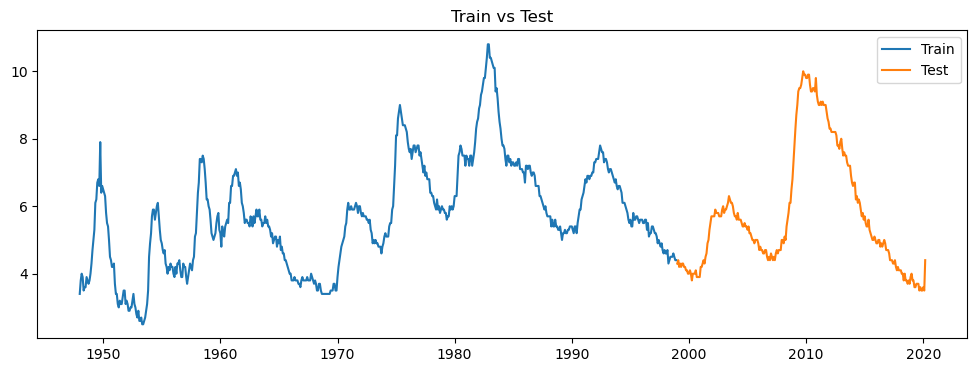

In [11]:
##Plotting the graph
plt.figure(figsize=(12,4))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.title('Train vs Test')
plt.legend(loc='best')
plt.show()

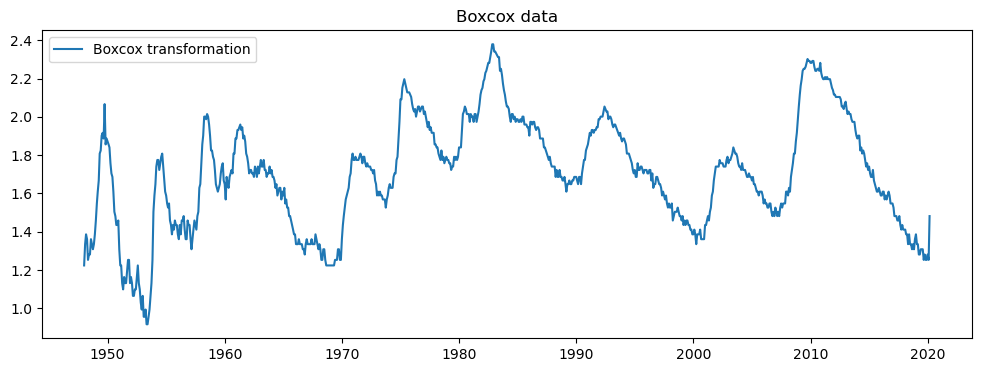

In [13]:
##boxcox transformation
from scipy.stats import boxcox
df_boxcox = pd.Series(boxcox(df['Unemployement_Rate'],lmbda=0),index = df.index)
plt.figure(figsize=(12,4))
plt.plot(df_boxcox,label='Boxcox transformation')
plt.title('Boxcox data')
plt.legend(loc='best')
plt.show()

### 1st Differencing

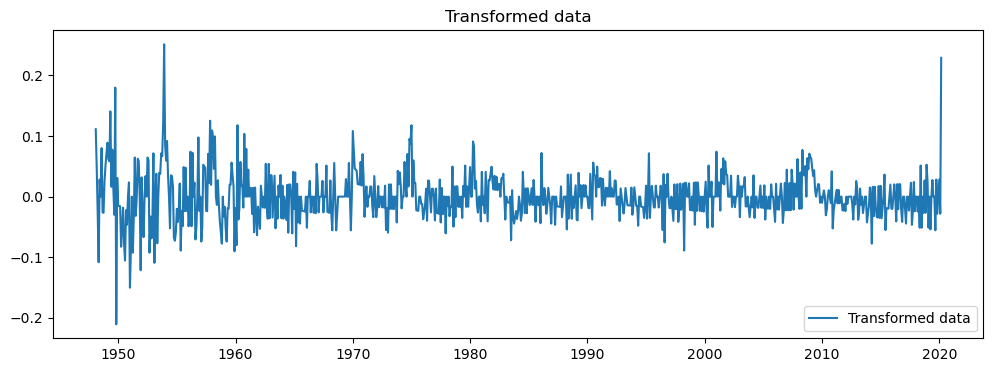

In [14]:
df_boxcox_diff = pd.Series(df_boxcox-df_boxcox.shift(),index = df.index)
df_boxcox_diff.dropna(inplace=True)

plt.figure(figsize=(12,4))
plt.plot(df_boxcox_diff,label='Transformed data')
plt.title('Transformed data')
plt.legend(loc='best')
plt.show()

### AR Method

In [17]:
train_boxcox_diff = df_boxcox_diff[:train_len-1]
test_boxcox_diff = df_boxcox_diff[train_len-1:]

In [18]:
train_boxcox_diff.shape,test_boxcox_diff.shape

((611,), (255,))

In [38]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_boxcox_diff,order=(12,0,0))
model_fit = model.fit()

C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [39]:
## Recovering the original time series
from scipy.special import inv_boxcox
y_hat_ar = df_boxcox_diff.copy()
y_hat_ar['ar_boxcox_diff'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_hat_ar['ar_boxcox'] = y_hat_ar['ar_boxcox_diff'].cumsum()
y_hat_ar['ar_boxcox'] = y_hat_ar['ar_boxcox'].add(df_boxcox[0])
# y_hat_ar['ar_forecast'] =np.exp(y_hat_ar['ar_boxcox'])  #inversing boxcox
y_hat_ar['ar_forecast'] = inv_boxcox(y_hat_ar['ar_boxcox'],0)

In [40]:
##rmse and mape
from sklearn.metrics import mean_squared_error
rmse = round(np.sqrt(mean_squared_error(test['Unemployement_Rate'],y_hat_ar['ar_forecast'][test.index.min():])),2)
mape =round( np.mean((np.abs(test['Unemployement_Rate']-y_hat_ar['ar_forecast'][test.index.min():]))/test['Unemployement_Rate']*100),2)
print('RMSE:',rmse)
print('MAPE:',mape)

RMSE: 2.07
MAPE: 21.5


### MA method

In [30]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_boxcox_diff,order=(0,0,1))
model_fit = model.fit()

C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
## Recovering the original time series
from scipy.special import inv_boxcox
y_hat_ma = df_boxcox_diff.copy()
y_hat_ma['ma_boxcox_diff'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_hat_ma['ma_boxcox'] = y_hat_ma['ma_boxcox_diff'].cumsum()
y_hat_ma['ma_boxcox'] = y_hat_ma['ma_boxcox'].add(df_boxcox[0])
y_hat_ma['ma_forecast'] = inv_boxcox(y_hat_ma['ma_boxcox'],0)

In [33]:
##rmse and mape
from sklearn.metrics import mean_squared_error
rmse = round(np.sqrt(mean_squared_error(test['Unemployement_Rate'],y_hat_ma['ma_forecast'][test.index.min():])),2)
mape =round( np.mean((np.abs(test['Unemployement_Rate']-y_hat_ma['ma_forecast'][test.index.min():]))/test['Unemployement_Rate']*100),2)
print('RMSE:',rmse)
print('MAPE:',mape)

RMSE: 2.11
MAPE: 21.64
